In [1]:
!pip install numpy pandas matplotlib scikit-learn opencv-python pillow torch torchvision

In [2]:
from PIL import Image
import os
from torchvision import transforms

In [3]:
def create_lr_images(hr_path,lr_path,scale):
    if not os.path.exists(lr_path):
        os.makedirs(lr_path)
    for filename in os.listdir(hr_path):
        hr_image = Image.open(os.path.join(hr_path,filename))
        lr_image = hr_image.resize((hr_image.width//scale, hr_image.height//scale), Image.BICUBIC)
        lr_image.save(os.path.join(lr_path,filename))

In [21]:
hr = "C:\image_super_resolution\general100\hr"
lr = "C:\image_super_resolution\general100\lr"
scale = 4
create_lr_images(hr,lr,scale)

C:\image_super_resolution\general100\lr


In [22]:
image_size = (256,256)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

C:\image_super_resolution\general100\lr


In [6]:
import torch
import torch.nn as nn

In [23]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN,self).__init__()
        self.conv1 = nn.Conv2d(3,64,kernel_size=9,padding=4)
        self.conv2 = nn.Conv2d(64,32,kernel_size=5,padding=2)
        self.conv3 = nn.Conv2d(32,3,kernel_size=5,padding=2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

C:\image_super_resolution\general100\lr


In [24]:
criterion = nn.MSELoss()
model = SRCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

C:\image_super_resolution\general100\lr


In [9]:
from torch.utils.data import DataLoader, Dataset

In [25]:
class ImageDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = Image.open(os.path.join(self.lr_dir, self.lr_images[idx]))
        hr_image = Image.open(os.path.join(self.hr_dir, self.hr_images[idx]))
        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)
        return lr_image, hr_image

C:\image_super_resolution\general100\lr


In [27]:
train_dataset = ImageDataset(lr, hr, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [28]:
num_epochs = 100

for epoch in range(num_epochs):
    for lr, hr in train_loader:
        optimizer.zero_grad()
        outputs = model(lr)
        loss = criterion(outputs, hr)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/100], Loss: 0.2393
Epoch [2/100], Loss: 0.1361
Epoch [3/100], Loss: 0.0778
Epoch [4/100], Loss: 0.0508
Epoch [5/100], Loss: 0.0609
Epoch [6/100], Loss: 0.0336
Epoch [7/100], Loss: 0.0327
Epoch [8/100], Loss: 0.0333
Epoch [9/100], Loss: 0.0182
Epoch [10/100], Loss: 0.0242
Epoch [11/100], Loss: 0.0249
Epoch [12/100], Loss: 0.0122
Epoch [13/100], Loss: 0.0157
Epoch [14/100], Loss: 0.0300
Epoch [15/100], Loss: 0.0186
Epoch [16/100], Loss: 0.0201
Epoch [17/100], Loss: 0.0235
Epoch [18/100], Loss: 0.0194
Epoch [19/100], Loss: 0.0147
Epoch [20/100], Loss: 0.0211
Epoch [21/100], Loss: 0.0169
Epoch [22/100], Loss: 0.0137
Epoch [23/100], Loss: 0.0168
Epoch [24/100], Loss: 0.0181
Epoch [25/100], Loss: 0.0194
Epoch [26/100], Loss: 0.0148
Epoch [27/100], Loss: 0.0131
Epoch [28/100], Loss: 0.0133
Epoch [29/100], Loss: 0.0144
Epoch [30/100], Loss: 0.0074
Epoch [31/100], Loss: 0.0121
Epoch [32/100], Loss: 0.0132
Epoch [33/100], Loss: 0.0246
Epoch [34/100], Loss: 0.0151
Epoch [35/100], Loss: 0

In [29]:
import numpy as np
import math
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0619067..1.0068806].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


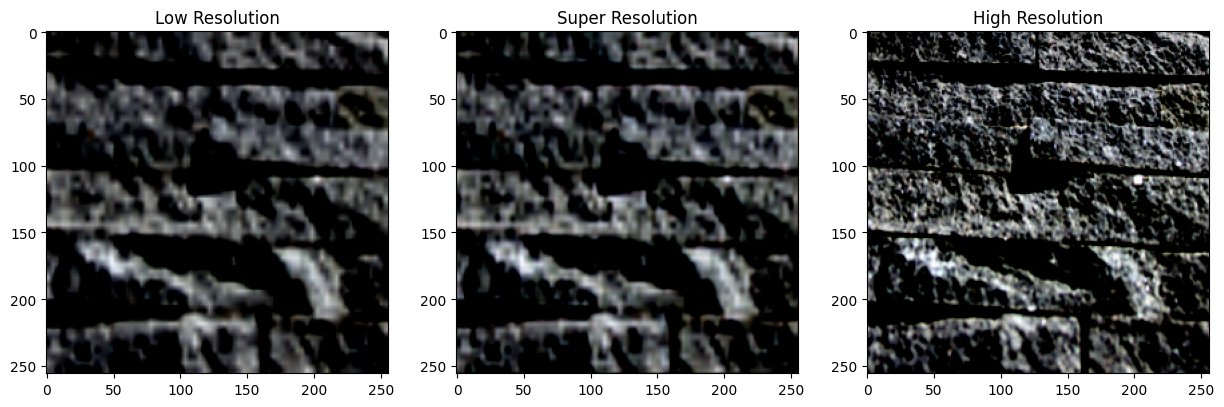

In [34]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def visualize_results(lr_image, sr_image, hr_image):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(lr_image.permute(1, 2, 0).numpy())
    axes[0].set_title('Low Resolution')
    axes[1].imshow(sr_image.permute(1, 2, 0).detach().numpy())
    axes[1].set_title('Super Resolution')
    axes[2].imshow(hr_image.permute(1, 2, 0).numpy())
    axes[2].set_title('High Resolution')
    plt.show()

# Load a sample image
lr_image, hr_image = train_dataset[0]
lr_image = lr_image.unsqueeze(0)  # Add batch dimension

# Super resolve the image
with torch.no_grad():
    sr_image = model(lr_image)

# Visualize the results
visualize_results(lr_image.squeeze(), sr_image.squeeze(), hr_image)


In [31]:
torch.save(model.state_dict(), 'srcnn_model.pth')